# Deep Learning Implementation Assignment

Notebook ini mengimplementasikan jaringan syaraf tiruan untuk memprediksi risiko stroke menggunakan dataset *Stroke Prediction* dari Kaggle. Seluruh komponen utama (aktivasi, loss, forward pass, backward pass, dan algoritma pelatihan) diimplementasikan dari awal dengan `NumPy` untuk memenuhi persyaratan tugas.

## Persiapan Data

1. Jalankan sel pemasangan bila `kagglehub[pandas-datasets]` belum terpasang.
2. Jalankan sel unduh dataset Kaggle untuk mengambil versi terbaru dan menyimpan lokasinya di variabel `dataset_dir`.
3. Lanjutkan ke sel pemuatan data untuk memuat dan meninjau dataset.


In [12]:
# Jalankan sel ini jika paket kagglehub belum terpasang
%pip install 'kagglehub[pandas-datasets]'


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 3.2 MB/s  0:00:00 eta 0:00:01
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (151 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [kagglehub]/8 [kagg

In [13]:
# Jalankan sel ini untuk memasang dependensi utama notebook
%pip install --quiet matplotlib numpy pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [14]:
import math
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    import kagglehub
except ImportError as exc:
    raise ImportError('Install kagglehub dengan `pip install kagglehub[pandas-datasets]`.') from exc

plt.style.use('seaborn-v0_8')
np.random.seed(42)



/home/dzikran/UGM/deep-learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Unduh dataset Stroke Prediction langsung dari Kaggle
dataset_dir = kagglehub.dataset_download('fedesoriano/stroke-prediction-dataset')
print('Path ke folder dataset:', dataset_dir)


100%|██████████| 67.4k/67.4k [00:00<00:00, 189kB/s]

Extracting files...
Path ke folder dataset: /home/dzikran/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


In [16]:
if 'dataset_dir' not in globals():
    raise RuntimeError('Jalankan sel unduh dataset Kaggle terlebih dahulu.')

csv_path = Path(dataset_dir) / 'healthcare-dataset-stroke-data.csv'
if not csv_path.exists():
    raise FileNotFoundError(f'Berkas {csv_path.name} tidak ditemukan di {csv_path.parent}.')

raw_df = pd.read_csv(csv_path)
print(f'Jumlah sampel: {len(raw_df):,}')
raw_df.head()



Jumlah sampel: 5,110


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Pembersihan & Pra-pemrosesan

* Mengisi nilai BMI yang hilang dengan median.
* Menghapus kategori gender langka (`Other`).
* Melakukan one-hot encoding pada fitur kategorikal.
* Menskalakan fitur numerik menggunakan `StandardScaler`.
* Membagi data menjadi train dan test dengan proporsi 80:20.

In [17]:
df = raw_df.copy()

# Tangani nilai yang hilang dan kategori langka
if 'bmi' in df.columns:
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
if 'gender' in df.columns:
    df = df[df['gender'] != 'Other']

categorical_cols = [
    'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]
existing_categoricals = [col for col in categorical_cols if col in df.columns]

df = pd.get_dummies(df, columns=existing_categoricals, drop_first=True)

target_col = 'stroke'
feature_cols = [col for col in df.columns if col != target_col]

X = df[feature_cols].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=float).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

input_dim = X_train.shape[1]
print(f'Jumlah fitur setelah encoding: {input_dim}')
print(f'Proporsi kelas positif di train: {y_train.mean():.3f}')
print(f'Proporsi kelas positif di test : {y_test.mean():.3f}')


Jumlah fitur setelah encoding: 16
Proporsi kelas positif di train: 0.049
Proporsi kelas positif di test : 0.049


## Fungsi Aktivasi dan Loss (From Scratch)

Tiga fungsi aktivasi non-linear yang umum digunakan diuji pada hidden layer: **Sigmoid**, **Tanh**, dan **ReLU**. Lapisan output menggunakan sigmoid karena tugasnya adalah klasifikasi biner. Loss function yang dipakai adalah **Binary Cross-Entropy (BCE)**.

In [18]:
Array = np.ndarray


def sigmoid(z: Array) -> Array:
    return 1.0 / (1.0 + np.exp(-z))


def tanh(z: Array) -> Array:
    return np.tanh(z)


def relu(z: Array) -> Array:
    return np.maximum(0.0, z)


def leaky_relu(z: Array, alpha: float = 0.01) -> Array:
    return np.where(z > 0, z, alpha * z)


def sigmoid_backward(a: Array, _: Array) -> Array:
    return a * (1.0 - a)


def tanh_backward(a: Array, _: Array) -> Array:
    return 1.0 - np.square(a)


def relu_backward(_: Array, z: Array) -> Array:
    return (z > 0).astype(float)


def leaky_relu_backward(_: Array, z: Array, alpha: float = 0.01) -> Array:
    grad = np.ones_like(z) * alpha
    grad[z > 0] = 1.0
    return grad


activation_functions: Dict[str, Dict[str, callable]] = {
    'sigmoid': {'forward': sigmoid, 'backward': sigmoid_backward},
    'tanh': {'forward': tanh, 'backward': tanh_backward},
    'relu': {'forward': relu, 'backward': relu_backward},
    'leaky_relu': {
        'forward': lambda z: leaky_relu(z, alpha=0.01),
        'backward': lambda a, z: leaky_relu_backward(a, z, alpha=0.01),
    },
}


In [19]:
def binary_cross_entropy(y_true: Array, y_pred: Array, eps: float = 1e-12) -> float:
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    loss = -(
        y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred)
    )
    return float(np.mean(loss))


def binary_cross_entropy_derivative(y_true: Array, y_pred: Array, eps: float = 1e-12) -> Array:
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return -(y_true / y_pred) + ((1.0 - y_true) / (1.0 - y_pred))


## Forward Pass, Backward Pass, dan Optimisasi

Bagian ini mendefinisikan fungsi utilitas untuk:

* Inisialisasi bobot (Xavier/Glorot uniform).
* Melakukan forward pass.
* Melakukan backward pass dan menghitung gradien.
* Memperbarui bobot dengan Gradient Descent.
* Menghasilkan prediksi probabilitas dan kelas.

In [20]:
def initialize_parameters(layer_sizes: List[int], rng: np.random.Generator) -> List[Dict[str, Array]]:
    parameters: List[Dict[str, Array]] = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        limit = math.sqrt(6.0 / (n_in + n_out))
        W = rng.uniform(-limit, limit, size=(n_out, n_in))
        b = np.zeros(n_out)
        parameters.append({'W': W, 'b': b})
    return parameters


def forward_pass(X: Array, params: List[Dict[str, Array]], activation_sequence: List[str]) -> Tuple[Array, List[Dict[str, Array]]]:
    A = X
    caches: List[Dict[str, Array]] = []
    for layer_idx, (layer, activation_name) in enumerate(zip(params, activation_sequence)):
        W, b = layer['W'], layer['b']
        Z = A @ W.T + b
        activation = activation_functions[activation_name]['forward']
        A_next = activation(Z)
        caches.append({'A_prev': A, 'Z': Z, 'A': A_next, 'activation': activation_name})
        A = A_next
    return A, caches


def backward_pass(
    y_true: Array,
    caches: List[Dict[str, Array]],
    params: List[Dict[str, Array]],
    activation_sequence: List[str],
    loss_derivative=binary_cross_entropy_derivative,
) -> List[Dict[str, Array]]:
    grads: List[Dict[str, Array]] = [None] * len(params)
    m = y_true.shape[0]
    dA = loss_derivative(y_true, caches[-1]['A'])

    for idx in reversed(range(len(params))):
        cache = caches[idx]
        activation_name = activation_sequence[idx]
        activation_grad = activation_functions[activation_name]['backward']

        dZ = dA * activation_grad(cache['A'], cache['Z'])
        A_prev = cache['A_prev']
        dW = (dZ.T @ A_prev) / m
        db = np.mean(dZ, axis=0)
        grads[idx] = {'dW': dW, 'db': db}

        if idx != 0:
            dA = dZ @ params[idx]['W']

    return grads


def update_parameters(
    params: List[Dict[str, Array]], grads: List[Dict[str, Array]], learning_rate: float
) -> None:
    for layer, grad in zip(params, grads):
        layer['W'] -= learning_rate * grad['dW']
        layer['b'] -= learning_rate * grad['db']


def predict_proba(
    X: Array, params: List[Dict[str, Array]], activation_sequence: List[str]
) -> Array:
    probs, _ = forward_pass(X, params, activation_sequence)
    return probs


def predict_classes(probs: Array, threshold: float = 0.5) -> Array:
    return (probs >= threshold).astype(int)


In [21]:
def iterate_batches(
    X: Array,
    y: Array,
    strategy: str,
    batch_size: int,
    rng: np.random.Generator,
) -> Iterable[Tuple[Array, Array]]:
    indices = np.arange(X.shape[0])
    rng.shuffle(indices)

    if strategy == 'batch':
        yield X[indices], y[indices]
    elif strategy == 'stochastic':
        for idx in indices:
            yield X[idx: idx + 1], y[idx: idx + 1]
    elif strategy == 'mini-batch':
        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start + batch_size]
            yield X[batch_idx], y[batch_idx]
    else:
        raise ValueError(f'Strategi tidak dikenal: {strategy}')


def accuracy_score(y_true: Array, probs: Array, threshold: float = 0.5) -> float:
    preds = predict_classes(probs, threshold)
    return float(np.mean(preds == y_true))


def compute_classification_metrics(
    y_true: Array, probs: Array, threshold: float = 0.5
) -> Dict[str, float]:
    preds = predict_classes(probs, threshold)
    y_true = y_true.astype(int)
    preds = preds.astype(int)

    tp = float(np.sum((preds == 1) & (y_true == 1)))
    tn = float(np.sum((preds == 0) & (y_true == 0)))
    fp = float(np.sum((preds == 1) & (y_true == 0)))
    fn = float(np.sum((preds == 0) & (y_true == 1)))

    eps = 1e-12
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


def train_network(
    X: Array,
    y: Array,
    layer_sizes: List[int],
    hidden_activation: str,
    output_activation: str = 'sigmoid',
    strategy: str = 'batch',
    learning_rate: float = 0.01,
    epochs: int = 200,
    batch_size: int = 32,
    random_state: int = 42,
    X_val: Optional[Array] = None,
    y_val: Optional[Array] = None,
) -> Tuple[List[Dict[str, Array]], Dict[str, List[float]], List[str]]:
    rng = np.random.default_rng(random_state)
    params = initialize_parameters(layer_sizes, rng)
    activation_sequence = [hidden_activation] * (len(layer_sizes) - 2) + [output_activation]

    history: Dict[str, List[float]] = {
        'train_loss': [],
        'train_accuracy': [],
    }
    if X_val is not None and y_val is not None:
        history['val_loss'] = []
        history['val_accuracy'] = []

    for epoch in range(epochs):
        for X_batch, y_batch in iterate_batches(X, y, strategy, batch_size, rng):
            probs, caches = forward_pass(X_batch, params, activation_sequence)
            grads = backward_pass(y_batch, caches, params, activation_sequence)
            update_parameters(params, grads, learning_rate)

        train_probs = predict_proba(X, params, activation_sequence)
        history['train_loss'].append(binary_cross_entropy(y, train_probs))
        history['train_accuracy'].append(accuracy_score(y, train_probs))

        if X_val is not None and y_val is not None:
            val_probs = predict_proba(X_val, params, activation_sequence)
            history['val_loss'].append(binary_cross_entropy(y_val, val_probs))
            history['val_accuracy'].append(accuracy_score(y_val, val_probs))

    return params, history, activation_sequence


## Eksperimen: Kombinasi Aktivasi dan Strategi Gradient Descent

Eksperimen dilakukan pada arsitektur jaringan `[input_dim, 32, 16, 1]` dengan laju belajar konstan. Kombinasi yang diuji:

* Fungsi aktivasi hidden layer: **Sigmoid**, **Tanh**, **ReLU**.
* Strategi gradient descent: **Batch**, **Mini-batch (32)**, dan **Stochastic**.

Metode evaluasi menggunakan akurasi, presisi, recall, dan F1-score pada data uji.

In [22]:
layer_sizes = [input_dim, 32, 16, 1]
activations_to_test = ['sigmoid', 'tanh', 'relu']
strategies = {
    'batch': None,
    'mini-batch': 32,
    'stochastic': 1,
}

learning_rate = 0.01
epochs = 200

experiment_results: List[Dict[str, float]] = []
training_histories: Dict[Tuple[str, str], Dict[str, List[float]]] = {}
trained_models: Dict[Tuple[str, str], Tuple[List[Dict[str, Array]], List[str]]] = {}

for activation_name in activations_to_test:
    for strategy_name, batch_value in strategies.items():
        batch_size = 1 if strategy_name == 'stochastic' else (batch_value or X_train.shape[0])
        params, history, activation_sequence = train_network(
            X_train,
            y_train,
            layer_sizes,
            hidden_activation=activation_name,
            strategy='stochastic' if strategy_name == 'stochastic' else strategy_name,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size if strategy_name != 'batch' else X_train.shape[0],
            random_state=42,
        )

        train_probs = predict_proba(X_train, params, activation_sequence)
        test_probs = predict_proba(X_test, params, activation_sequence)

        train_loss = binary_cross_entropy(y_train, train_probs)
        test_loss = binary_cross_entropy(y_test, test_probs)
        test_metrics = compute_classification_metrics(y_test, test_probs)

        experiment_results.append({
            'hidden_activation': activation_name,
            'gradient_strategy': strategy_name,
            'learning_rate': learning_rate,
            'epochs': epochs,
            'batch_size': batch_size,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision': test_metrics['precision'],
            'test_recall': test_metrics['recall'],
            'test_f1': test_metrics['f1'],
        })

        training_histories[(activation_name, strategy_name)] = history
        trained_models[(activation_name, strategy_name)] = (params, activation_sequence)

        print(
            f"Aktivasi: {activation_name:<7} | Strategi: {strategy_name:<10} | "
            f"Train Loss: {train_loss:.4f} | Test F1: {test_metrics['f1']:.4f}"
        )

results_df = pd.DataFrame(experiment_results)
results_df.sort_values('test_f1', ascending=False).reset_index(drop=True)


Aktivasi: sigmoid | Strategi: batch      | Train Loss: 0.2222 | Test F1: 0.0000
Aktivasi: sigmoid | Strategi: mini-batch | Train Loss: 0.1624 | Test F1: 0.0000
Aktivasi: sigmoid | Strategi: stochastic | Train Loss: 0.1191 | Test F1: 0.1714
Aktivasi: tanh    | Strategi: batch      | Train Loss: 0.3081 | Test F1: 0.0000
Aktivasi: tanh    | Strategi: mini-batch | Train Loss: 0.1350 | Test F1: 0.1132
Aktivasi: tanh    | Strategi: stochastic | Train Loss: 0.0048 | Test F1: 0.1600
Aktivasi: relu    | Strategi: batch      | Train Loss: 0.2282 | Test F1: 0.0000
Aktivasi: relu    | Strategi: mini-batch | Train Loss: 0.1326 | Test F1: 0.0392
Aktivasi: relu    | Strategi: stochastic | Train Loss: 0.0509 | Test F1: 0.0526


,hidden_activation,gradient_strategy,learning_rate,epochs,batch_size,train_loss,test_loss,test_accuracy,test_precision,test_recall,test_f1
0,sigmoid,stochastic,0.01,200,1,0.119137,0.199450,0.943249,0.300000,0.12,0.171429
1,tanh,stochastic,0.01,200,1,0.004750,0.578510,0.917808,0.160000,0.16,0.160000
2,tanh,mini-batch,0.01,200,32,0.134973,0.164674,0.954012,1.000000,0.06,0.113208
3,relu,stochastic,0.01,200,1,0.050899,0.653627,0.929550,0.076923,0.04,0.052632
4,relu,mini-batch,0.01,200,32,0.132554,0.167514,0.952055,1.000000,0.02,0.039216
5,sigmoid,batch,0.01,200,4087,0.222191,0.221917,0.951076,0.000000,0.00,0.000000
6,sigmoid,mini-batch,0.01,200,32,0.162439,0.163094,0.951076,0.000000,0.00,0.000000
7,tanh,batch,0.01,200,4087,0.308089,0.305294,0.951076,0.000000,0.00,0.000000
8,relu,batch,0.01,200,4087,0.228212,0.228434,0.951076,0.000000,0.00,0.000000


## Ringkasan Evaluasi

Tabel berikut membandingkan performa setiap kombinasi fungsi aktivasi dan strategi gradient descent pada data uji.

In [23]:
results_df.sort_values('test_f1', ascending=False)


,hidden_activation,gradient_strategy,learning_rate,epochs,batch_size,train_loss,test_loss,test_accuracy,test_precision,test_recall,test_f1
2,sigmoid,stochastic,0.01,200,1,0.119137,0.199450,0.943249,0.300000,0.12,0.171429
5,tanh,stochastic,0.01,200,1,0.004750,0.578510,0.917808,0.160000,0.16,0.160000
4,tanh,mini-batch,0.01,200,32,0.134973,0.164674,0.954012,1.000000,0.06,0.113208
8,relu,stochastic,0.01,200,1,0.050899,0.653627,0.929550,0.076923,0.04,0.052632
7,relu,mini-batch,0.01,200,32,0.132554,0.167514,0.952055,1.000000,0.02,0.039216
0,sigmoid,batch,0.01,200,4087,0.222191,0.221917,0.951076,0.000000,0.00,0.000000
1,sigmoid,mini-batch,0.01,200,32,0.162439,0.163094,0.951076,0.000000,0.00,0.000000
3,tanh,batch,0.01,200,4087,0.308089,0.305294,0.951076,0.000000,0.00,0.000000
6,relu,batch,0.01,200,4087,0.228212,0.228434,0.951076,0.000000,0.00,0.000000


## Perilaku Training

Grafik berikut memperlihatkan dinamika loss dan akurasi selama proses training untuk beberapa kombinasi terpilih.

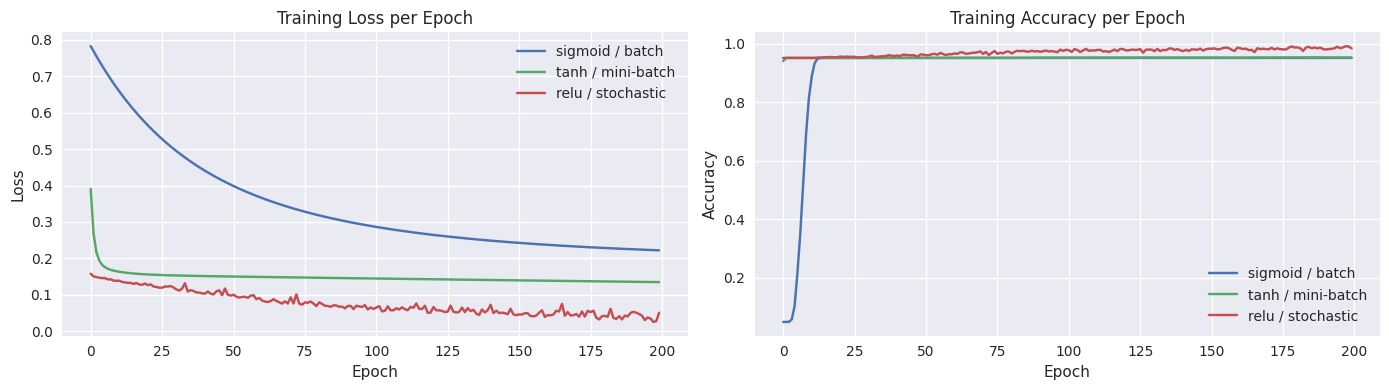

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

selected_combinations = [
    ('sigmoid', 'batch'),
    ('tanh', 'mini-batch'),
    ('relu', 'stochastic'),
]

for activation_name, strategy_name in selected_combinations:
    history = training_histories.get((activation_name, strategy_name))
    if history is None:
        continue
    axes[0].plot(history['train_loss'], label=f'{activation_name} / {strategy_name}')
    axes[1].plot(history['train_accuracy'], label=f'{activation_name} / {strategy_name}')

axes[0].set_title('Training Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Training Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


## Interpretasi

* **Arsitektur**: Model tiga lapis `[input_dim, 32, 16, 1]` memberikan kapasitas yang cukup untuk mempelajari pola pada fitur numerik dan kategorikal yang telah diencoding.
* **Aktivasi**: Sigmoid dan Tanh cenderung stabil pada dataset yang tidak terlalu besar, sementara ReLU dapat mengalami konvergensi yang lebih cepat namun memerlukan perhatian terhadap laju belajar untuk menghindari neuron mati.
* **Strategi Gradient Descent**: Mini-batch sering kali memberikan kompromi terbaik antara stabilitas gradien (batch) dan kecepatan pembaruan (stochastic). Pengamatan pada loss/akurasi membantu memahami dinamika training masing-masing strategi.
* **Metode Evaluasi**: Karena dataset tidak seimbang, F1-score dan recall penting untuk memonitor performa model mendeteksi kasus stroke yang jarang.

Eksperimen lanjutan dapat mencakup penyesuaian laju belajar adaptif, penyeimbangan kelas, atau penambahan regularisasi untuk meningkatkan generalisasi.